
## MUIZ ADEKOMI
## Project Topic: Using Linear Discriminant Analysis for Classification and Showing the Effect of K-fold validation on the robustness


### Coourse Sp25 - 63-SUBSURFACE MACHINE LEARNING (20335) 
## Spring 2025
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### University of Texas at Austin


#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin	
#### Course TA: Elnara Rustamzade


### Linear Discriminant Analysis
Linear Discriminant Analysis (LDA) is a supervised machine learning method primarily utilized for classification tasks and reducing the number of dimensions in a dataset. It achieves this by creating linear combinations of the features that effectively distinguish between two or more classes. The technique works by transforming the data into a lower-dimensional space, ensuring that the distance between the means of different classes is as large as possible (to keep the classes distinct), while also minimizing the variability within each class.

### Steps for this project
1. Packages for carrying out analysis are imported
2. Initial visualization and data inspection
3. Split data into train and test
4. Build model
5. Assesss accuracy matric
6. Do a k-fold validation
7. Do a final summary

### Executive Summary
This project addresses the challenge of effectively classifying subsurface reservoir properties, specifically focusing on production rates based on geophysical features such as porosity and brittleness. The opportunity lies in utilizing Linear Discriminant Analysis (LDA) to create a model that distinguishes between high and low production categories using these features. To achieve this, an LDA model was trained on a dataset that included porosity, brittleness, and production levels, with preprocessing steps applied to handle negative values and a categorical production variable. The results showed that LDA effectively separated production categories, demonstrating that features such as porosity and brittleness exhibit a Gaussian distribution and support LDA assumptions. Despite a high accuracy score, k-fold validation only yielded marginal improvements in the model. It is recommended to explore additional features and refine the model using other validation methods to improve robustness, particularly for higher-dimensional datasets, to achieve more accurate classification

### Project Dataset
This project utilized the dataset "unconv_MV_v5.csv" from Prof. Pyrcz which can be found in GeostatsGuy's Github. Big thanks to Prof. Pyrcz!

### Import Packages

In [183]:
import os                                                 # To set working directory.
import pandas as pd                                        # For data manipulation with DataFrames.
import numpy as np                                         # For numerical operations on arrays and matrices.
import seaborn as sns                                      # For statistical data visualization.
import matplotlib.pyplot as plt                           # For creating visualizations and plots.
import matplotlib.gridspec as gridspec                     # For creating visualizations and plots.
import sklearn                                            # For machine learning models and utilities.
from sklearn.model_selection import train_test_split      # To split data into training and testing sets.
from sklearn.preprocessing import StandardScaler, LabelEncoder    # For scaling features and encoding labels.
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # For performing Linear Discriminant Analysis (LDA).
from sklearn.model_selection import cross_val_score           # For performing cross-validation and evaluating model accuracy.
from sklearn.decomposition import PCA                            # For PCA projection, compared to LDA
from sklearn.manifold import TSNE                            # for performing t-SNE dimensionality projection compared to LDA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix #performance matrix for model
from matplotlib import colors                              # For color management in plots.
import warnings                                             # For clearing unecessary warnings
cmap = plt.cm.inferno                                     # To apply the 'inferno' colormap for visualizations.
from sklearn.manifold import TSNE

### Visualization Function

In [187]:
def plot_corr(dataframe, size=11):                               # Creates a correlation matrix heatmap for visualizing feature relationships
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr, vmin=-1.0, vmax=1.0, cmap=cmap)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.colorbar(im, orientation='vertical')
    plt.title('Correlation Matrix')

def plot_lda_scatter(lda, X, y):
    transformed_features = lda.transform(X)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=transformed_features[:, 0], y=[0] * len(transformed_features), hue=y)  # Plot only the first LDA dimension
    plt.title('LDA Scatter Plot')
    plt.xlabel('LDA Dimension A')
    plt.show()

def visualize_classification(model, xfeature, yfeature, target, scaler=None, plot_step=1000, cmap_name='plasma'):  # Visualizes classification results using contour and scatter plots.
    cmap = plt.get_cmap(cmap_name)    # Set up the desired colormap
    # Define axis limits for the plot
    x_min, x_max = min(xfeature), max(xfeature) 
    y_min, y_max = min(yfeature), max(yfeature)

    # Generate meshgrid for contour plotting
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, plot_step),
                         np.linspace(y_min, y_max, plot_step))

    # Predict class labels for each grid point
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Inverse transform the grid if a scaler is provided
    if scaler:
        trans = scaler.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
        trans_x, trans_y = trans[:, 0].reshape(xx.shape), trans[:, 1].reshape(xx.shape)
    else:
        trans_x, trans_y = xx, yy

    # Create contour plot for predicted classes
    cs = plt.contourf(trans_x, trans_y, Z, cmap=cmap, alpha=0.5)

    # Scatter plot for the original data points
    im = plt.scatter(xfeature, yfeature, c=target, cmap=cmap, edgecolors="black", linewidths=0.5)
   
    # Label axes and add colorbar
    plt.xlabel('Porosity')
    plt.ylabel('Brittleness')
    cbar = plt.colorbar(im, orientation='vertical', label='Production')

    return plt.gca()

# Some visualization code was taken from Professor Michael Pyrcz ebook https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html

### Loading Data

In this project, we will be working with the following features::

* **Porosity** - storability of the reservoir rock 
* **Permeability** - the ability of a fluid to flow through the rock in milidarcy
* **Acoustic Impedence** - product of sonic velocity and rock density in kg/m^2s*10^3
* **Production** - volume of hydrocarbon production per day in MCFPD

In [189]:
df = pd.read_csv("https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v5.csv")  # data can be found in Geostatsguy Github page
df.head(n=3)  #Inspect first three rows of the data

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574


### Data Inspection and Preprocessing

Reviewing the dataset's summary statistics to identify any outliers or implausible values.

In [191]:
df = df.iloc[:,1:]          # remove the well index        
df.describe()               # describe summary statistics of data

,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


Upon reviewing the summary statistics, we identified anomalies in the form of negative values for Total Organic Carbon (TOC), a result that is physically unrealistic, as TOC values must be non-negative. Since the minimum valid value for this property is 0, we resolved this issue by replacing all negative TOC values with 0.
In addition, a categorical variable was introduced for production, using a threshold of 3,500 MCFPD (thousand cubic feet per day) to distinguish between high and low production cases. This classification simplifies the analysis of production trends across the dataset.

In [193]:
num = df._get_numeric_data()                      # Extract numeric columns from DataFrame
num[num < 0] = 0                                  # Replace negative values with 0
df['cProd'] = np.where(df['Prod'] >= 3500, 1, 0)    # Create binary production feature (1 if Prod ≥ 3500, else 0)
df.head(n=4)                                      # Show new first 4 rows of the DataFrame

,Por,Perm,AI,Brittle,TOC,VR,Prod,cProd
0,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191,1
1,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205,1
2,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574,1
3,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869,1


Now we visualize the preprocessed data by examining the pairplot and its distribution.


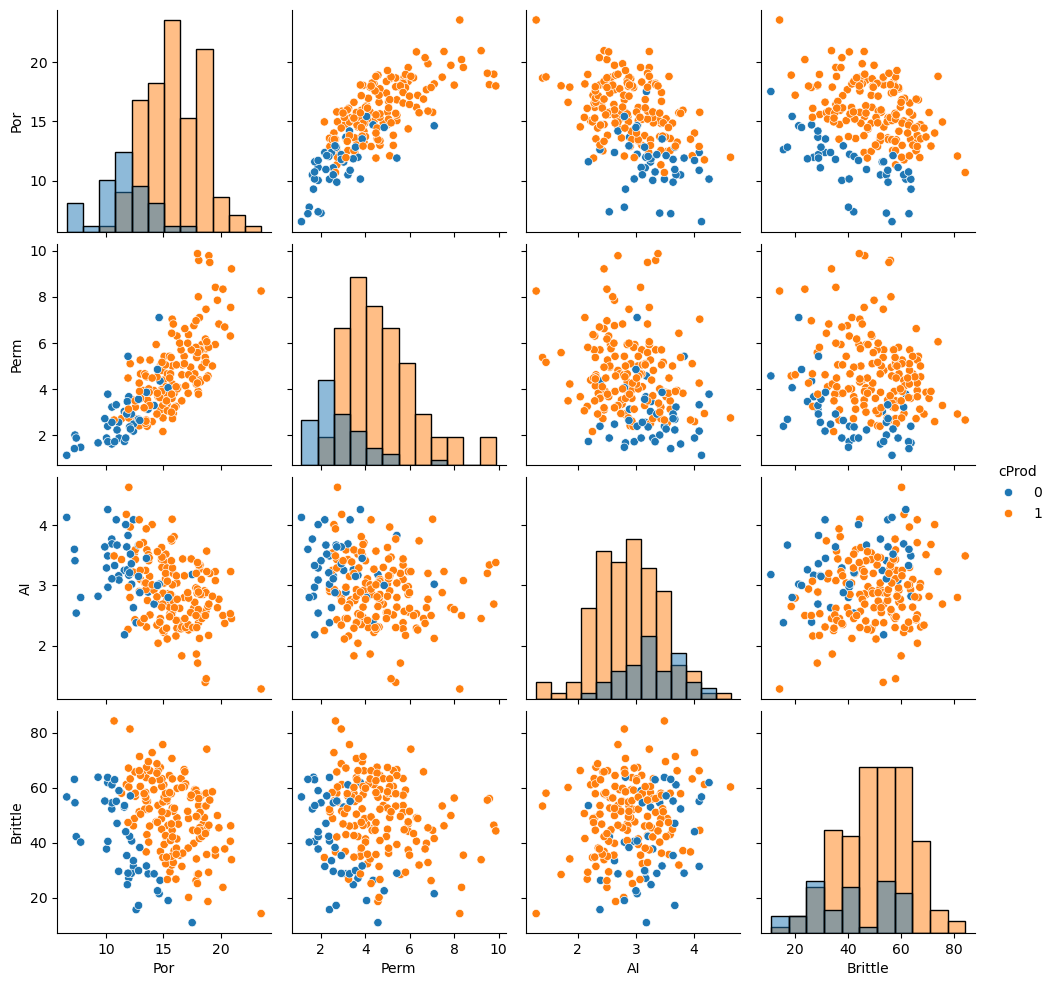

In [195]:
sns.pairplot(df,vars=['Por','Perm','AI', 'Brittle'],markers='o',hue='cProd', diag_kind="hist")

# Plot histograms for each numeric column to assess distribution
#df.hist(bins=20, figsize=(14, 10))
#plt.tight_layout()
#plt.show()

Each diagonal plot shows the distribution of a single feature, divided by cProd. This makes it easy to see whether feature values differ notably between high-production (cProd=1) and low-production (cProd=0) samples. If the histograms for cProd=1 and cProd=0 partially overlap but also have distinct regions, it suggests that these features may help differentiate between classes. Strong patterns in these scatterplots can guide the selection of features most useful for classification or regression models. When distinct groupings by hue appear, it often indicates that a supervised learning model (such as LDA or random forests) could effectively distinguish production levels using these features.
Porosity versus brittleness, for example, may exhibit distinct clustering between the two production categories, making these attributes strong discriminators for high versus low production. Both porosity and brittleness display a normal distribution within each category, meeting the assumptions of LDA. Normality is critical since LDA assumes that features follow a Gaussian distribution within each class. This observation supported the choice to use LDA with porosity and brittleness. Furthermore, the plots show that the combination of porosity and brittleness maintains a homoscedastic relationship, meaning that the data’s variability remains consistent across different levels of these variables

### Viewing the Correlation heatmap 


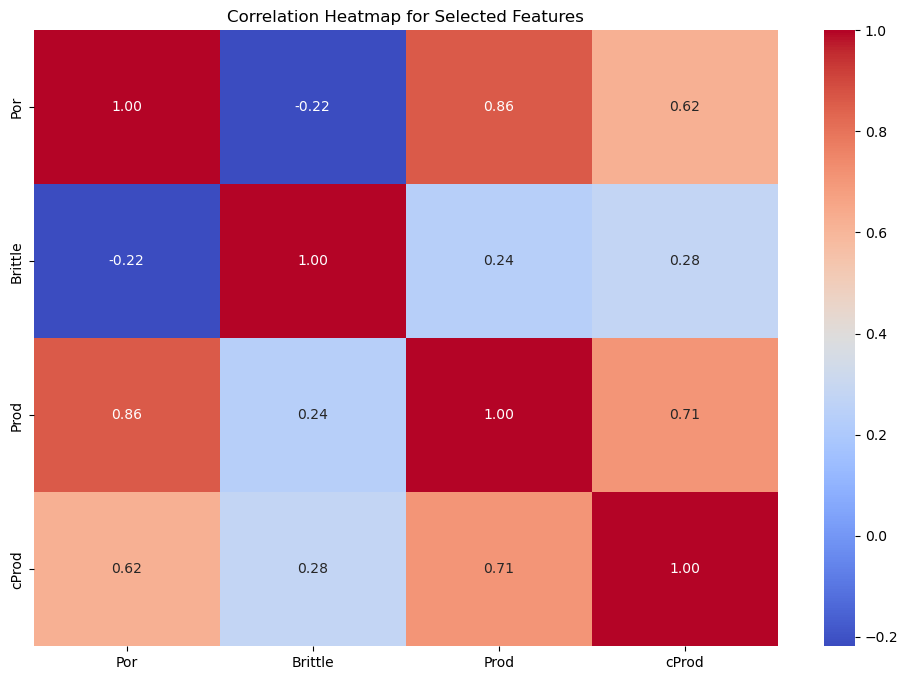

In [197]:
# Correlation heatmap
# Select the desired columns
selected_features = ['Por', 'Brittle', 'Prod', 'cProd']
corr_matrix = df[selected_features].corr()  # Create a correlation matrix for the selected features
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap for Selected Features')
plt.show()


This heatmap displays annotated correlation coefficients that help distinguish strong positive and negative associations using the coolwarm colormap. Notably, the analysis confirms that porosity and brittleness are largely uncorrelated meeting a key assumption for LDA. Consequently, these two features were selected for applying LDA, with low and high production levels serving as the target classes.

### Data Splitting into Train and Test Data
80% percent of the data was used to train the model and optimize its parameters for maximum accuracy, while the remaining 20% was reserved to evaluate its performance.

In [199]:
df_subset = df.iloc[:,[0,3,7]]                # extract just por, brittle and prod with 200 samples
X_train, X_test, y_train, y_test = train_test_split(df_subset.iloc[:,[0,1]], df_subset.iloc[:,2], test_size=0.20, random_state=7000)
y_train = pd.DataFrame({'cProd':y_train.values})
y_test = pd.DataFrame({'cProd':y_test.values})

#We set the minimum and maximum values for plotting
x1min = 5.0; x1max = 25.0
x2min = 0.0; x2max = 100.0
ymin = 0.0; ymax = 9000.0

After these steps, it's crucial to review the univariate distributions of Porosity, Brittleness, and Production, as they are key inputs for model development.

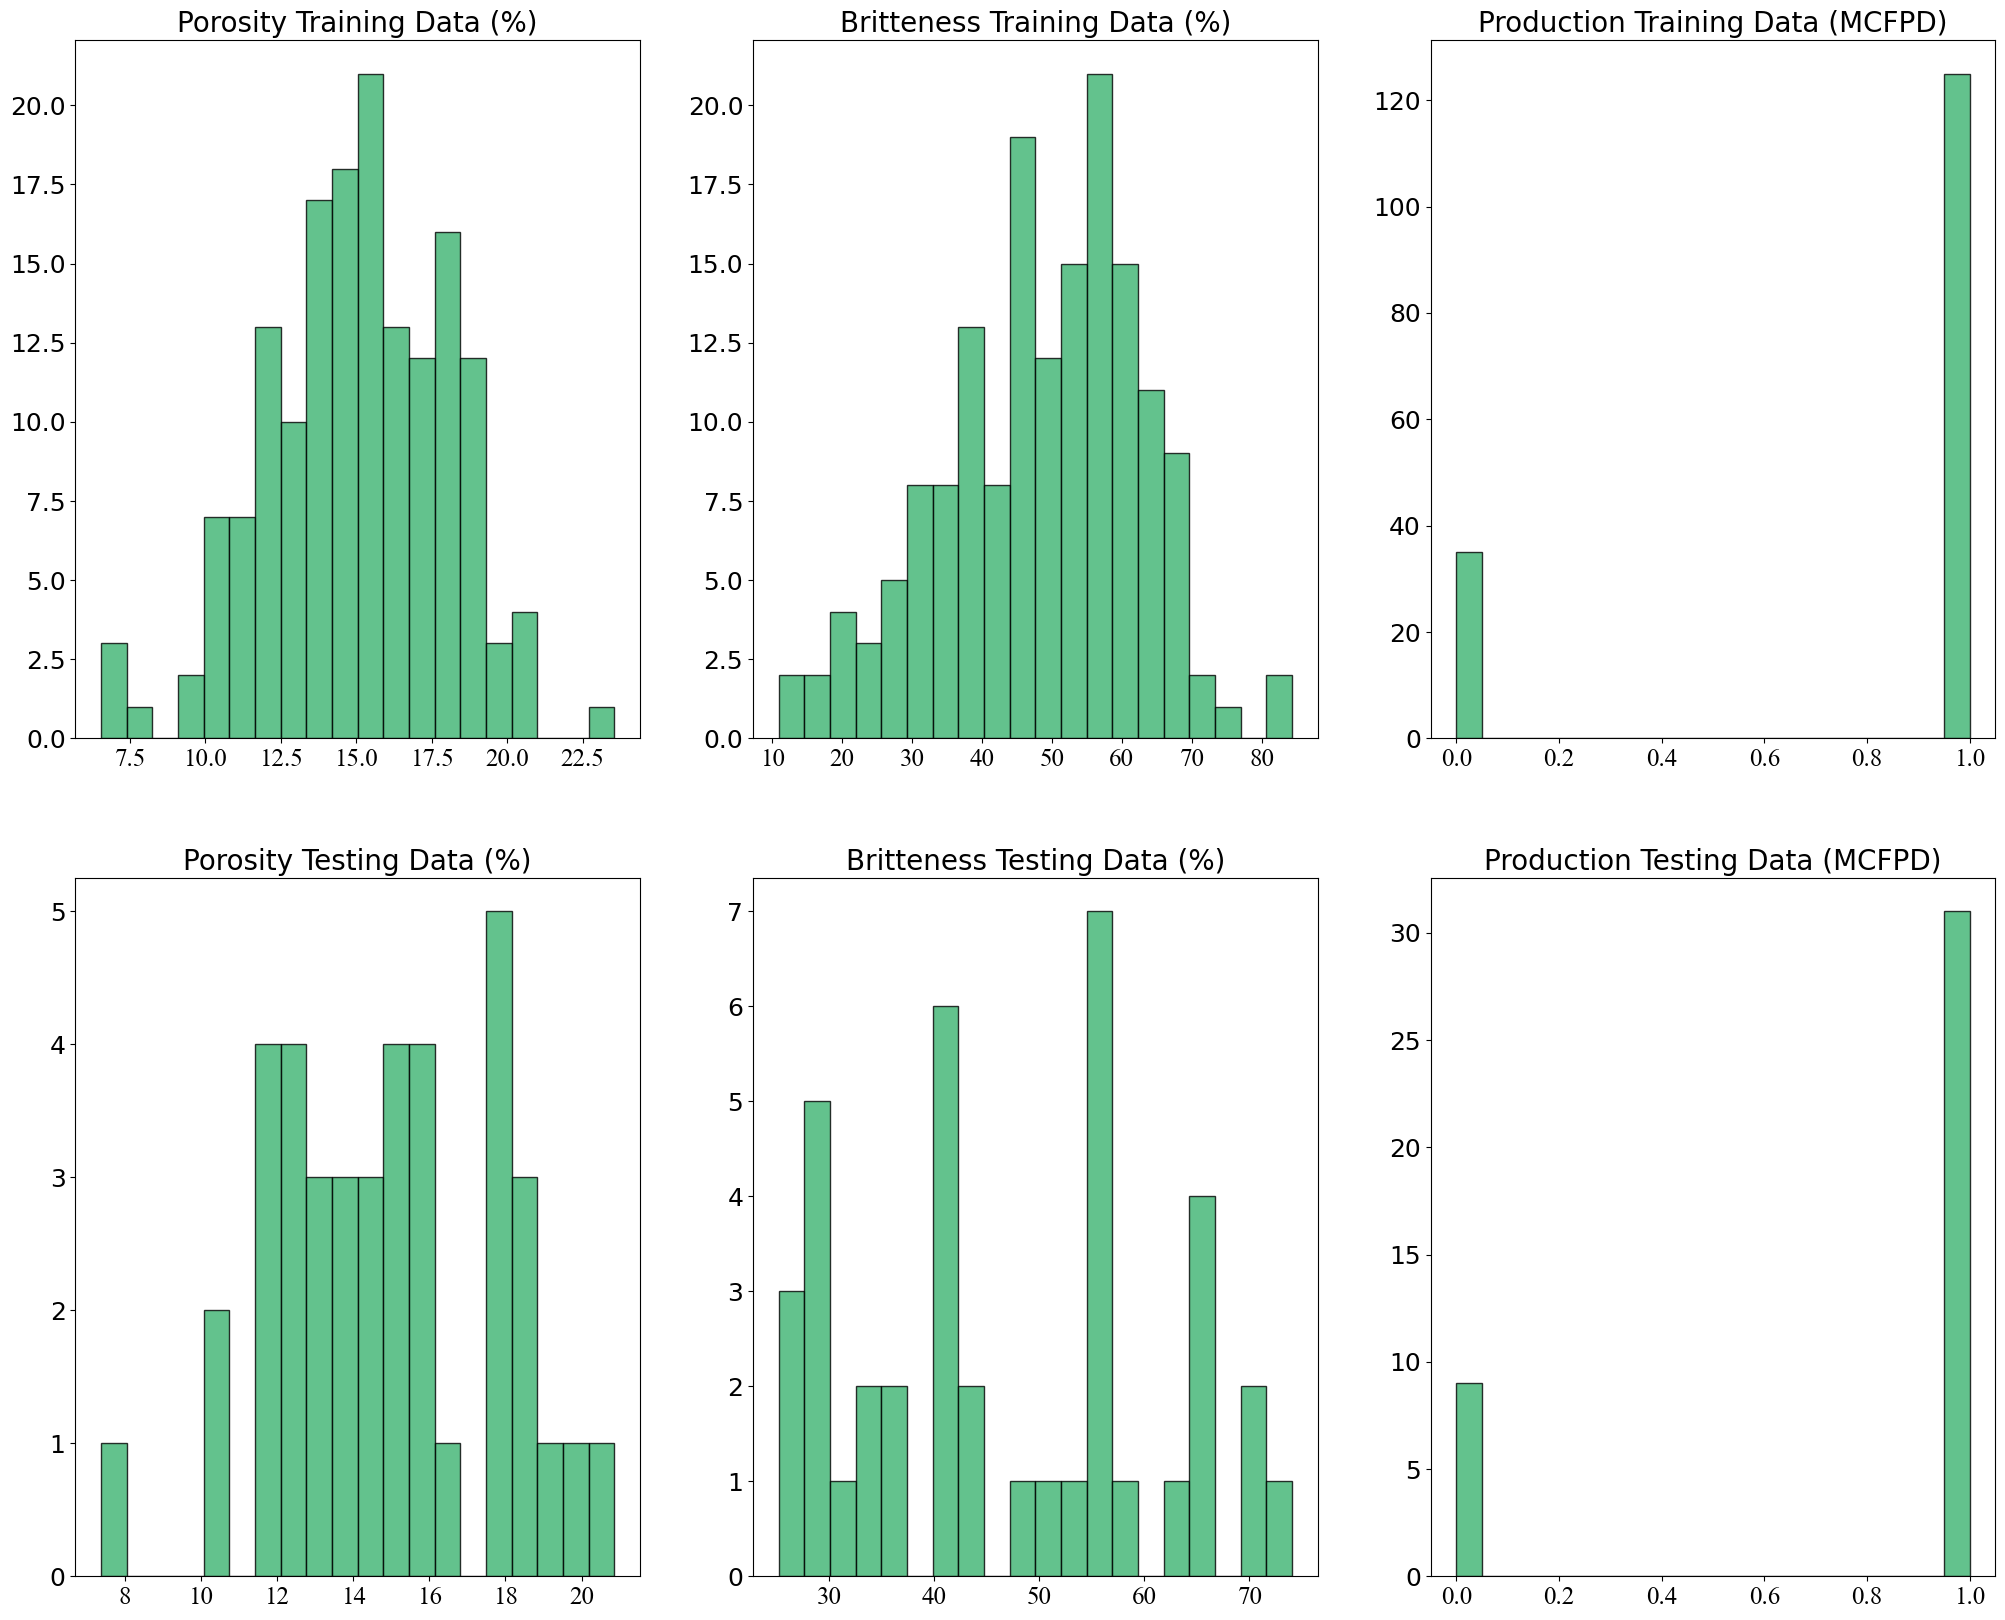

In [201]:
plt.subplot(231)
plt.hist(X_train["Por"], alpha = 0.8, color = 'mediumseagreen', edgecolor = 'black', bins=20)
plt.title('Porosity Training Data (%)', fontsize=20)
plt.xticks(fontsize=18, fontname="Times New Roman")
plt.yticks(fontsize=18)
           
plt.subplot(232)
plt.hist(X_train["Brittle"], alpha = 0.8, color = 'mediumseagreen', edgecolor = 'black', bins=20)
plt.title('Britteness Training Data (%)', fontsize=20)
plt.xticks(fontsize=18, fontname="Times New Roman")
plt.yticks(fontsize=18)

plt.subplot(233)
plt.hist(y_train['cProd'], alpha = 0.8, color = 'mediumseagreen', edgecolor = 'black', bins=20)
plt.title('Production Training Data (MCFPD)', fontsize=20)
plt.xticks(fontsize=18, fontname="Times New Roman")
plt.yticks(fontsize=18)

plt.subplot(234)
plt.hist(X_test["Por"], alpha = 0.8, color = 'mediumseagreen', edgecolor = 'black', bins=20)
plt.title('Porosity Testing Data (%)', fontsize=20)
plt.xticks(fontsize=18, fontname="Times New Roman")
plt.yticks(fontsize=18)

plt.subplot(235)
plt.hist(X_test["Brittle"], alpha = 0.8, color = 'mediumseagreen', edgecolor = 'black', bins=20)
plt.title('Britteness Testing Data (%)', fontsize=20)
plt.xticks(fontsize=18, fontname="Times New Roman")
plt.yticks(fontsize=18)

plt.subplot(236)
plt.hist(y_test['cProd'], alpha = 0.8, color = 'mediumseagreen', edgecolor = 'black', bins=20)
plt.title('Production Testing Data (MCFPD)', fontsize=20)
plt.xticks(fontsize=18, fontname="Times New Roman")
plt.yticks(fontsize=18)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.2, wspace=0.2, hspace=0.2)
plt.show()

#visualization code credit Geostatspy ebook -https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html

The individual feature distributions appear smooth and continuous, with no noticeable gaps or truncation issues. This suggests the data is reliable for further analysis. To gain additional insight into the relationships between these variables, we can generate a scatter plot of Porosity versus Brittleness, where each point is color-coded based on its corresponding Production value. This visualization will help us observe any potential patterns or trends that link the reservoir properties to production performance.

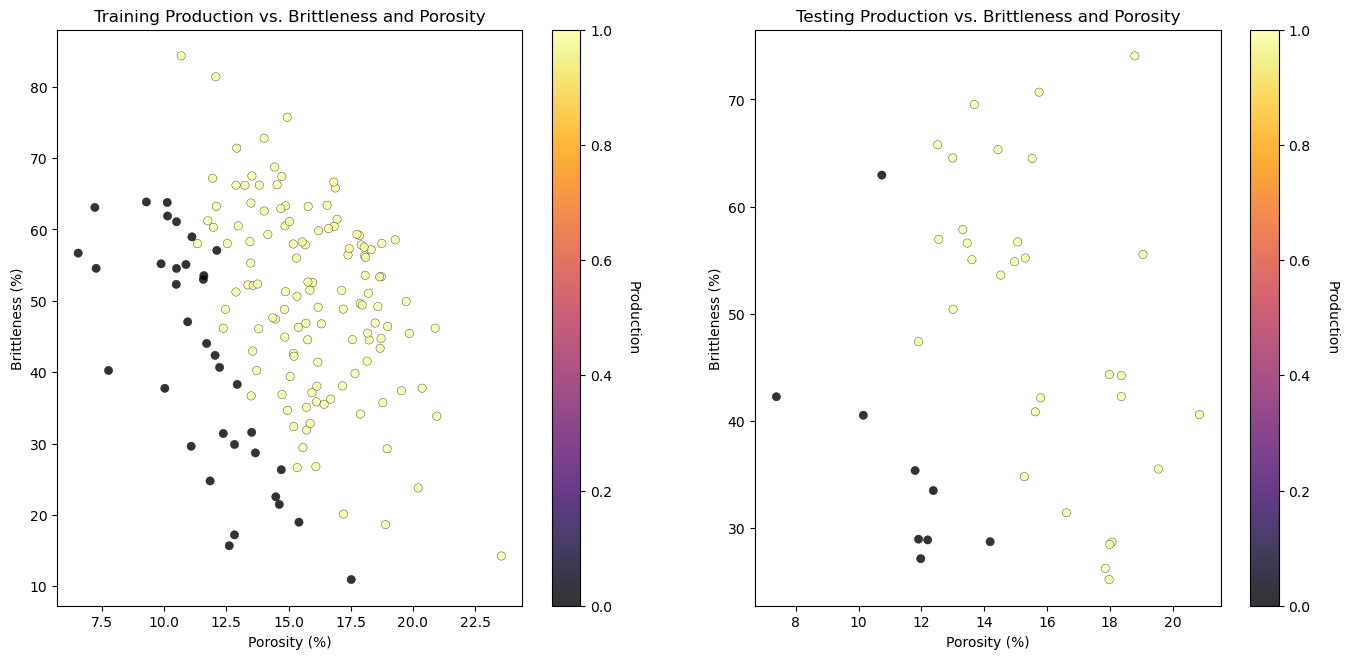

In [203]:
plt.subplot(121)
im = plt.scatter(X_train["Por"],X_train["Brittle"],s=None, c=y_train['cProd'], marker=None, cmap=cmap, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Training Production vs. Brittleness and Porosity'); plt.xlabel('Porosity (%)'); plt.ylabel('Brittleness (%)')
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Production", rotation=270, labelpad=20)

plt.subplot(122)
im = plt.scatter(X_test["Por"],X_test["Brittle"],s=None, c=y_test['cProd'], marker=None, cmap=cmap, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Testing Production vs. Brittleness and Porosity'); plt.xlabel('Porosity (%)'); plt.ylabel('Brittleness (%)')
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label("Production", rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)

plt.show()

#visualization code credit Geostatspy ebook -https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html

### Building The LDA Model

LDA involves computing the mean and covariance matrix of the data. When features have different scales, the contribution of each feature to these calculations can be dominated by the feature with the larger scale. In this project, the porosity and brittleness are both of the same scale (%), hence, there is no need for standardization of the features before applying LDA

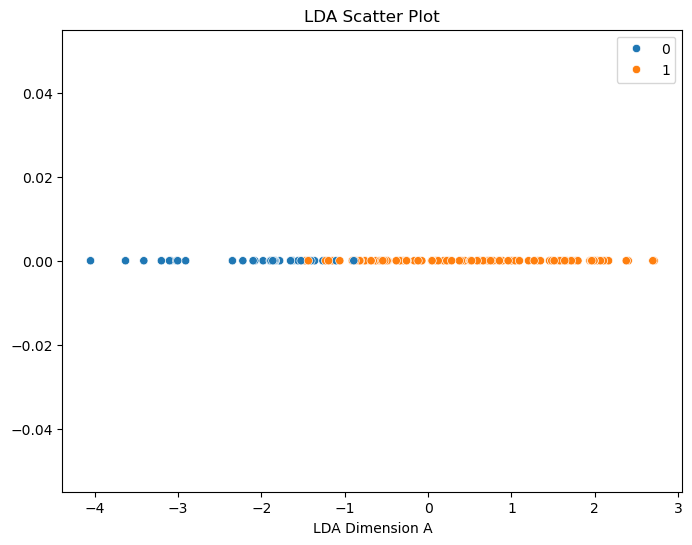

In [205]:
lda = LinearDiscriminantAnalysis(n_components=1)  # Initialize LDA to reduce data to a single discriminant component
X_tf = lda.fit(X_train, y_train.values.ravel())     # Fit the LDA model on the training data with flattened target labels

plot_lda_scatter(lda, X_train, y_train.values.ravel())

In this section, we focus on applying Linear Discriminant Analysis (LDA) to project the subsurface feature data specifically Porosity and Brittleness onto a lower-dimensional space that maximizes the separation between low and high production classes. This should provide a clear visualization of the class boundaries. To further understand how LDA performs in comparison to other dimensionality reduction techniques, we will present plots that contrast its results with those of PCA and t-SNE projections. This comparison will help illustrate how different methods capture the inherent structure in the data and clarify the class separations.

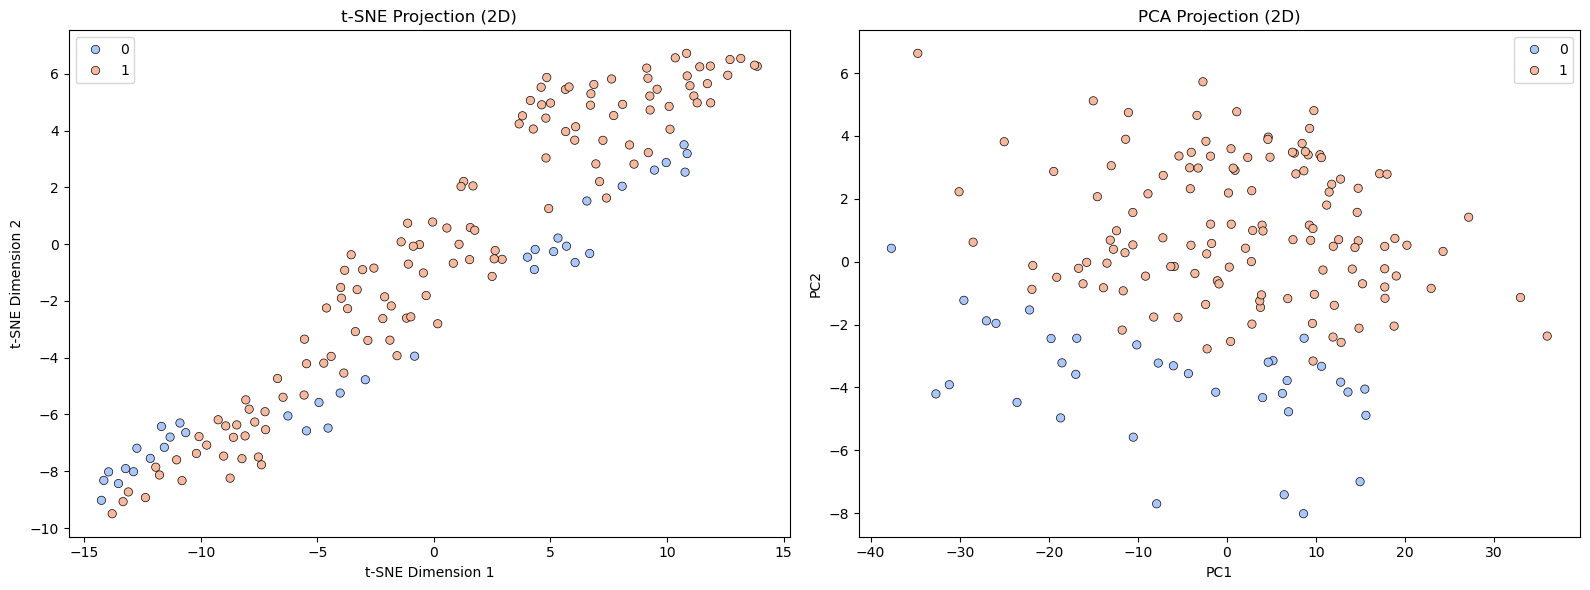

In [207]:
# Perform t-SNE with 2 components
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)

# Perform PCA with 2 components
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Create a figure with 2 subplots side by side
# t-SNE Plot
sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=y_train.values.ravel(), palette='coolwarm', edgecolor='black', ax=axes[0])
axes[0].set_title('t-SNE Projection (2D)')
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')
# PCA Plot
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train.values.ravel(), palette='coolwarm', edgecolor='black', ax=axes[1])
axes[1].set_title('PCA Projection (2D)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
plt.tight_layout() # Adjust layout to prevent overlap

plt.show()

The LDA-based scatter plot demonstrates how well LDA distinguishes between the production classes using Porosity and Brittleness. The scatter plot reveals a clear, although imperfect, separation between the classes, suggesting that these features have meaningful discriminative power. Notably, the PCA visualization, which focuses solely on capturing the greatest variance in the data, does not necessarily align as neatly with the production classes. This suggests that the main variance in the features is not entirely driven by production differences. Meanwhile, the t‑SNE plot, with its non-linear approach, uncovers subtle, complex relationships among the features. LDA provides a targeted, supervised projection for classification, making it well-suited for this intended investigation.

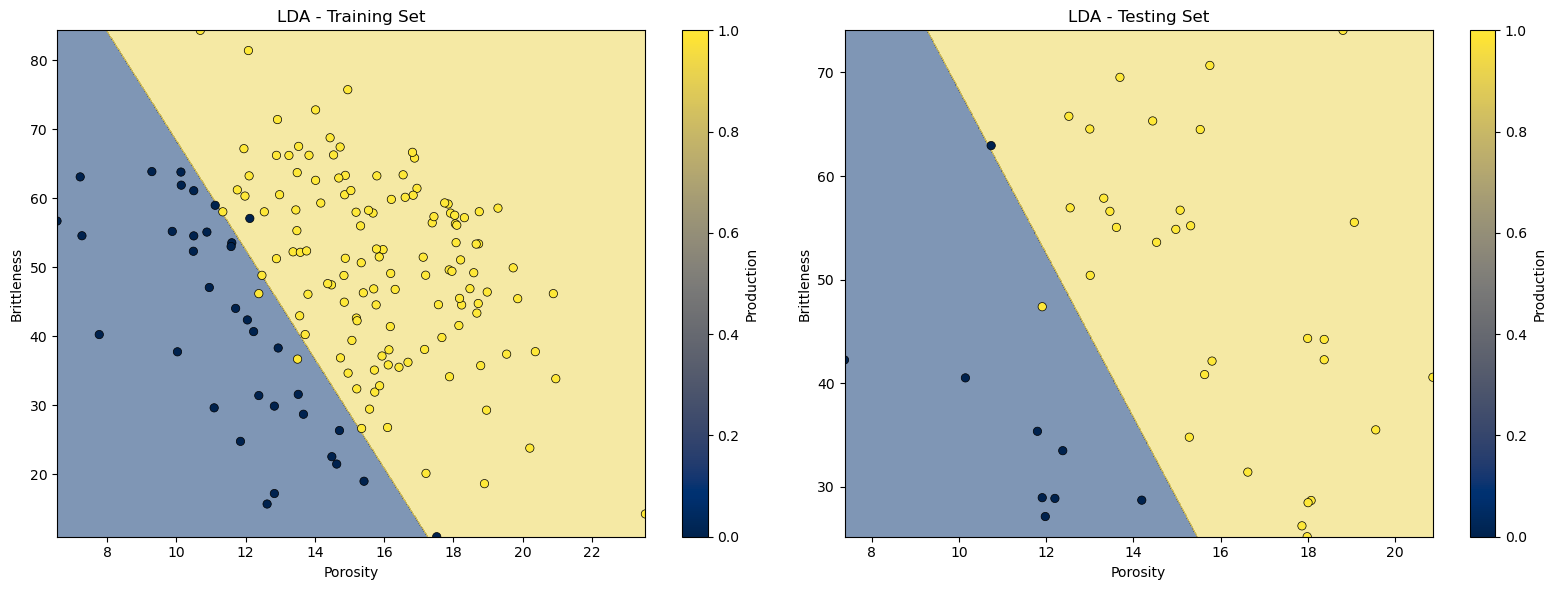

In [209]:
#Showing model results

fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # Create a figure with 2 subplots (side by side)
# Training set plot
plt.sca(axes[0])  # Set the current axis to axes[0]
Show_train = visualize_classification(lda, X_train['Por'], X_train['Brittle'], y_train.values.ravel(), scaler=None, plot_step=1000, cmap_name='cividis')
axes[0].set_title('LDA - Training Set')

# Testing set plot
plt.sca(axes[1])  # Set the current axis to axes[1]
Show_test = visualize_classification(lda, X_test['Por'], X_test['Brittle'], y_test.values.ravel(), scaler=None, plot_step=1000, cmap_name='cividis')
axes[1].set_title('LDA - Testing Set')
warnings.filterwarnings("ignore", message=".*does not have valid feature names.*") # Suppress featurename warning
plt.tight_layout()
plt.show()

This LDA visualization highlights the model’s decision boundary in the porosity–brittleness space, revealing clearly separated clusters and distinct zones of influence that indicate effective class discrimination.

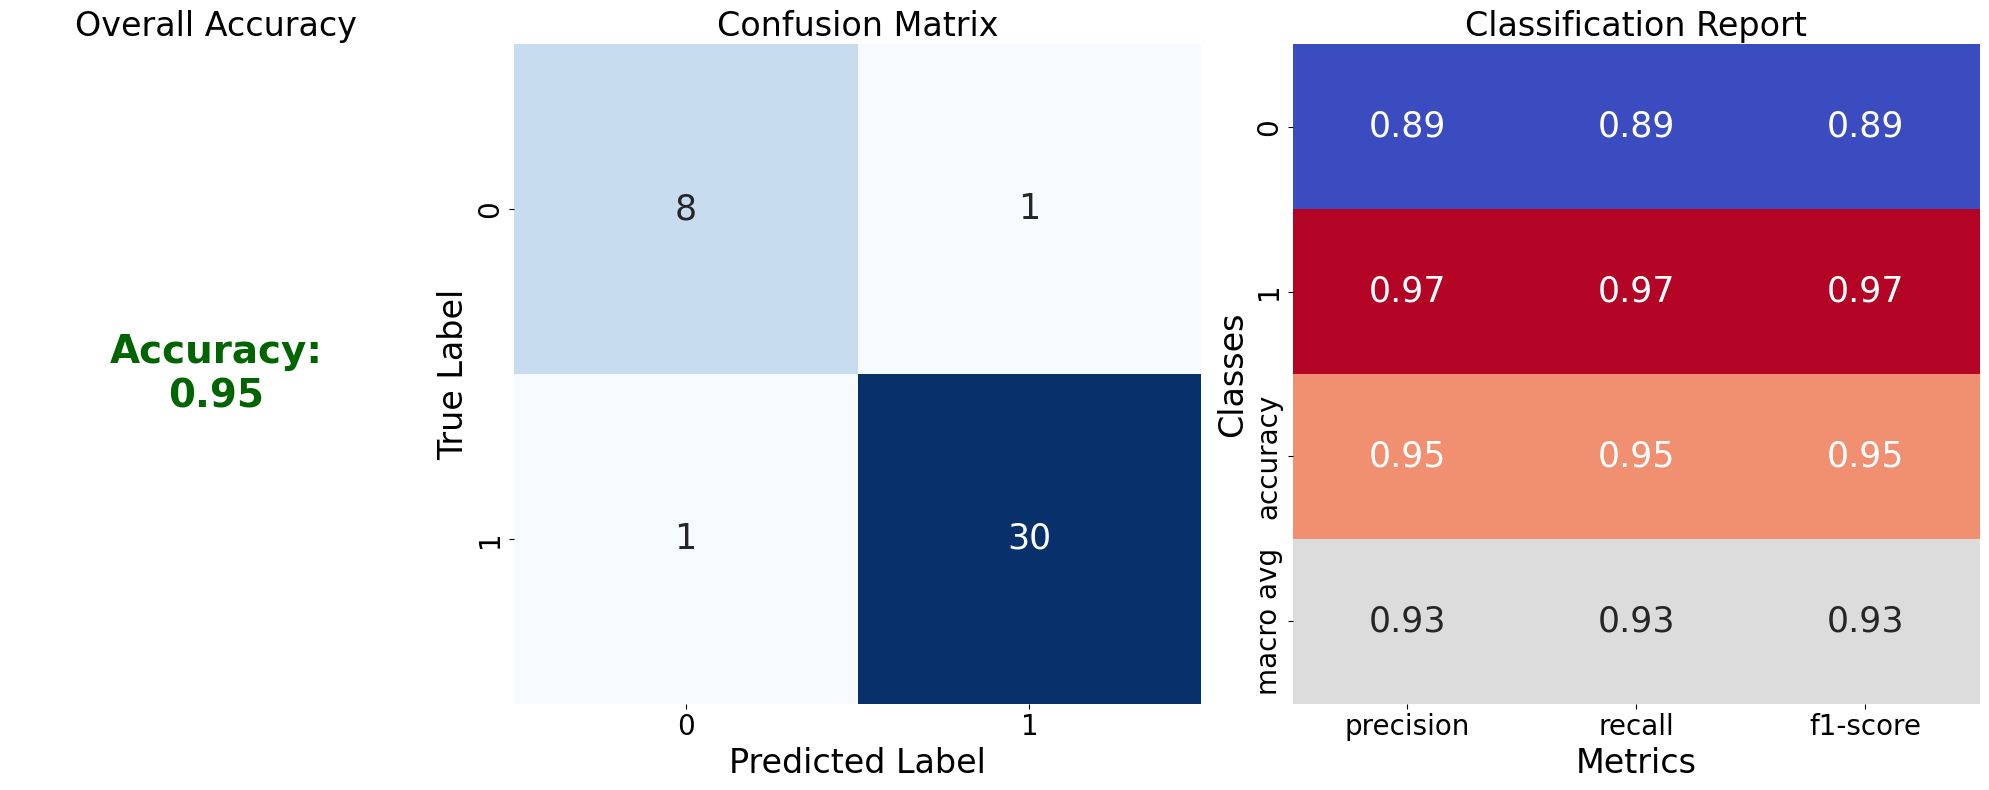

In [211]:
#  Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
cm = confusion_matrix(y_test, y_pred)

# Create a figure with three subplots using GridSpec for layout control
fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(1, 3, width_ratios=[0.6, 1, 1])  # Make First subplot narrower

# Subplot 1: Overall Accuracy
ax0 = fig.add_subplot(gs[0])
ax0.text(0.5, 0.5, f'Accuracy:\n{accuracy:.2f}', fontsize=28, ha='center', va='center', weight='bold', color='darkgreen')
ax0.axis('off')
ax0.set_title('Overall Accuracy', fontsize=24)

# Subplot 2: Confusion Matrix
ax1 = fig.add_subplot(gs[1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1, annot_kws={"fontsize": 25})
ax1.set_title('Confusion Matrix', fontsize=24)
ax1.set_xlabel('Predicted Label', fontsize=24)
ax1.set_ylabel('True Label', fontsize=24)
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=20)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)

# Subplot 3: Classification Report
df_report_view = df_report.drop(columns=['support'], errors='ignore')
ax2 = fig.add_subplot(gs[2])
sns.heatmap(df_report_view.iloc[:-1, :], annot=True, cmap='coolwarm', fmt='.2f', cbar=False, ax=ax2, annot_kws={"fontsize": 25})
ax2.set_title('Classification Report', fontsize=24)
ax2.set_xlabel('Metrics', fontsize=24)
ax2.set_ylabel('Classes', fontsize=24)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=20)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=20)

plt.tight_layout()
plt.show()


The LDA model achieved an accuracy of 0.95 on the testing dataset, meaning that it correctly classified a high proportion of samples. The classification report further details the model’s performance by presenting precision, recall, and F1-score for each class, while the confusion matrix breaks down the predictions into true positives, true negatives, false positives, and false negatives.

Next, we assess the robustness of our LDA model by performing cross-validation using a stratified 5-fold split. This approach ensures that each fold maintains the same class distribution as the overall dataset, which is critical for evaluating classification performance in imbalanced data. We use the cross_val_score function to compute accuracy scores for each of the five folds, which gives us insight into the variability and consistency of our model’s performance.

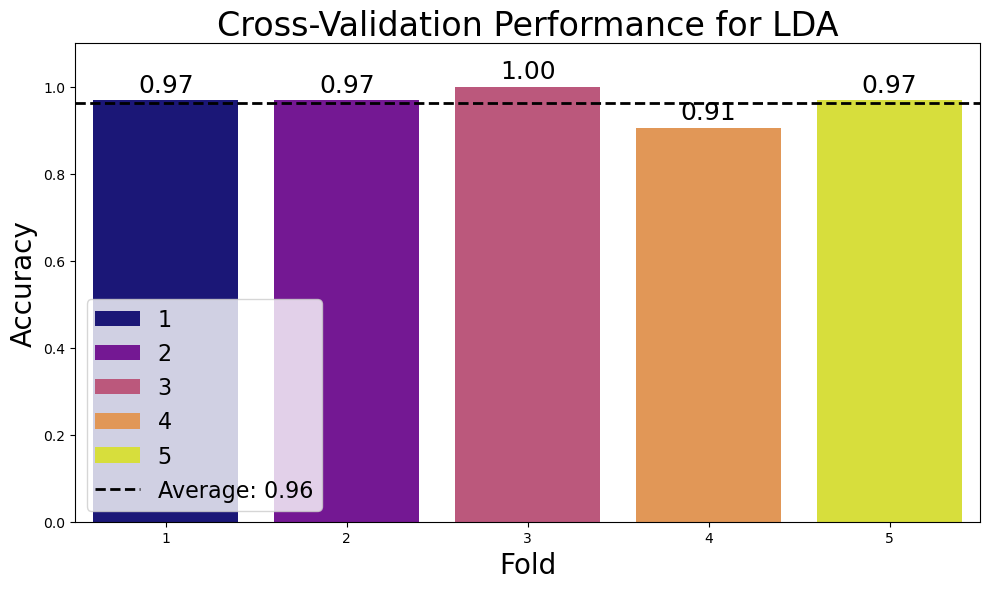

In [213]:
#k-Fold validation
# Perform 5-fold cross-validation for LDA
scores = cross_val_score(lda, X_train, y_train.values.ravel(), cv=5, scoring='accuracy')  # Get the accuracy scores

# Prepare a DataFrame with cross-validation scores
folds = np.arange(1, len(scores) + 1)
cv_df = pd.DataFrame({'Fold': folds, 'Accuracy': scores})
average_score = np.mean(scores)  # Calculate the average cross-validation score

# Plotting the cross-validation performance
plt.figure(figsize=(10, 6))
sns.barplot(data=cv_df, x='Fold', y='Accuracy', hue='Fold', palette='plasma', dodge=False)
plt.xlabel("Fold", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Cross-Validation Performance for LDA", fontsize=24)
plt.ylim(0, 1.1)
plt.legend([], [], frameon=False)  # Remove the legend since hue already mirrors the x-axis

# Annotate each bar with its accuracy score
for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center', fontsize=18)

# Draw a horizontal line for the average accuracy
plt.axhline(average_score, color='black', linewidth=2, linestyle='--', label=f"Average: {average_score:.2f}")
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()


Notably, the average k-fold accuracy (approximately 0.96) is very close to the previously obtained test set accuracy of 0.95, highlighting the consistency and robustness of the LDA model across different data splits. Interestingly, despite this initial high accuracy score, k-fold was able to improve it by 1.1%. This k-fold effect confirms that the model’s performance is stable and generalizes well to unseen data

This project demonstrates the effective use of Linear Discriminant Analysis (LDA) to classify subsurface production levels based on key features such as porosity and brittleness. The analysis revealed clear class separations and robust performance. The test set accuracy of approximately 0.95, supported and marginally improved by cross-validation, shows that LDA is both reliable and interpretable for classification problems.

## Muiz ADekomi, PhD Student, University of Texas at Austin

I have been doing a lot of cool work on making our energy industry sustainable. As a passionate advocate for sustainability, I am committed to developing sustainable solutions to both technical and non-technical challenges in the efficient exploitation of conventional and unconventional energy resources. My expertise encompasses carbon capture, utilization, and storage technologies, reservoir engineering, project economic analysis, and the application of data and machine learning to achieve net-zero emissions of processes. Kindly see my bios here for collaborations or opportunities https://www.linkedin.com/in/abdulmuizadekomi/

Regards

*Muiz*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
